In [3]:
! pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [22]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [23]:
image = cv.imread("./code0 (2) (1) (3).tif", cv.IMREAD_GRAYSCALE) #image charger en niveau de gris directement


assert image is not None, "file could not be read, check with os.path.exists()"

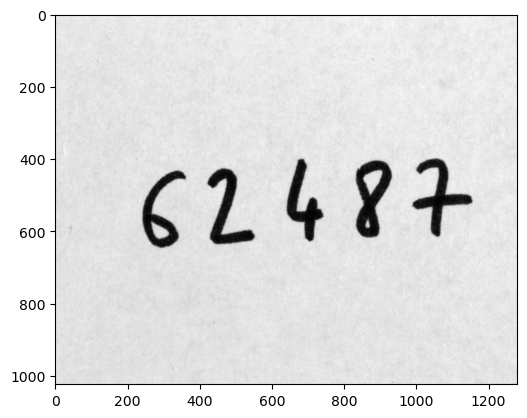

In [24]:
plt.imshow(image, cmap='gray')

## histogramme

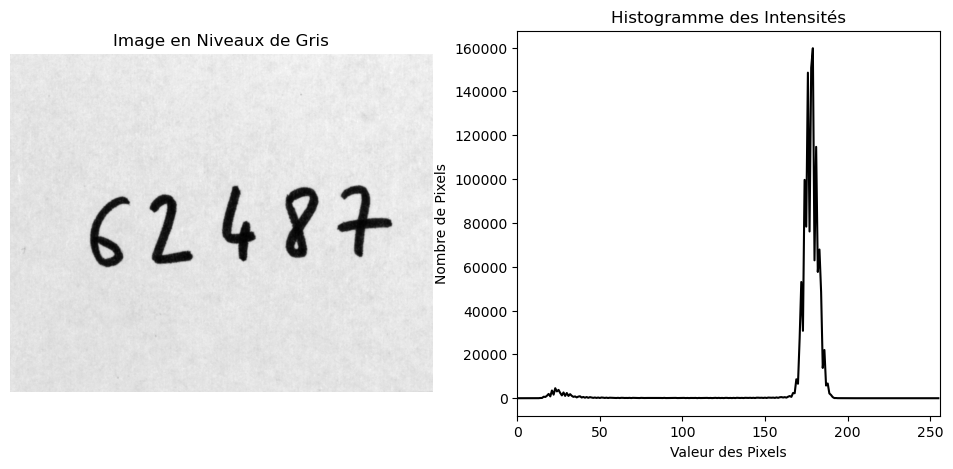

In [25]:
if image is None:
     print("Erreur : Impossible de lire l'image.")
else:
        # Calculer l'histogramme
        histogram = cv.calcHist([image], [0], None, [256], [0, 256])

        # Afficher l'image
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Image en Niveaux de Gris")
        plt.axis("off")

        # Afficher l'histogramme
        plt.subplot(1, 2, 2)
        plt.plot(histogram, color='black')
        plt.title("Histogramme des Intensités")
        plt.xlabel("Valeur des Pixels")
        plt.ylabel("Nombre de Pixels")
        plt.xlim([0, 256])  # Plage des valeurs de pixel

        plt.show()

In [26]:
def showHist(image):
    if image.ndim == 2:
        fig, axes = plt.subplots(1, 2, figsize=(9, 4))
        histr = cv.calcHist([image], [0], None, [256], [0, 256]).flatten()
        axes[1].bar(range(len(histr)), histr)
        axes[1].set_xlim([0, 256])
        axes[0].imshow(image, cmap="gray")
        axes[0].set_axis_off()
    else:
        color = ("b", "g", "r")
        for i, col in enumerate(color):
            histr = cv.calcHist([image], [i], None, [256], [0, 256])
            plt.plot(histr, color=col)
            plt.xlim([0, 256])
    plt.show()

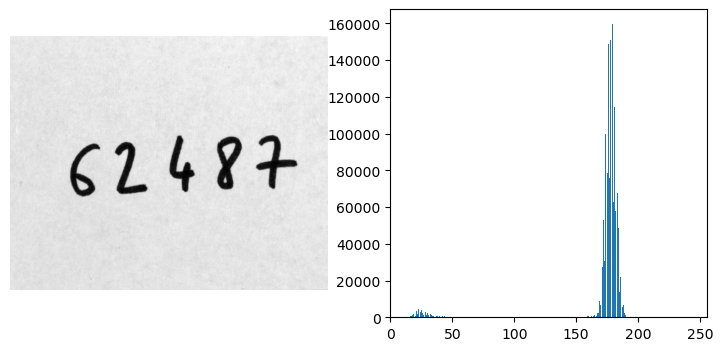

In [18]:
showHist(image)

## Binarisation

In [27]:

def binarize(image):
    tresh, img = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    return tresh, img.astype("uint8")

def showBinary(image):
    tresh, binary_img = binarize(image)
    plt.imshow(binary_img, cmap="gray")
    plt.title(f"Binarized image with a threshold value of {tresh}")
    plt.axis("off")
    plt.show()


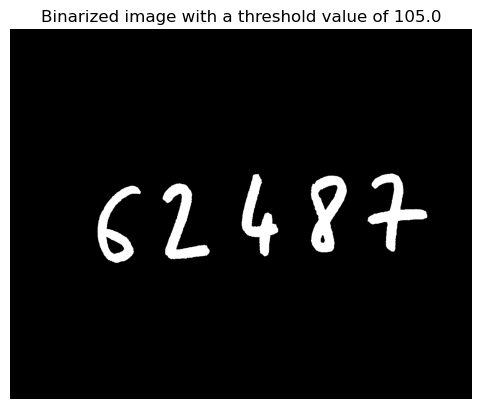

In [28]:
showBinary(image)

## Erosion

In [29]:

def enhance_img(image):
    kernel = np.ones((5, 5), np.uint8)
    image_erode = cv.erode(image, kernel, iterations=1)
    return image_erode


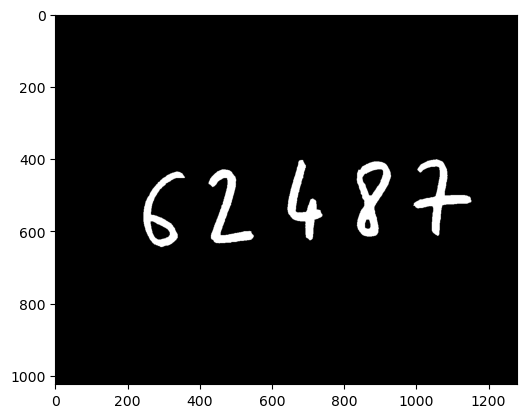

In [30]:
# Appliquer l'amélioration de l'image
eroded_image = enhance_img(binarize(image)[1])
plt.imshow(eroded_image , cmap='gray' )

## Identification des region de l'image

In [31]:
def connectedRegion(image):
    """
    Fonction qui détecte les régions connectées dans une image binaire et extrait chaque région sous forme de sous-image.

    :param image: Image binaire (noir et blanc) contenant les objets connectés.
    :return: L'image avec les contours dessinés + Liste des régions extraites.
    """

    # Étape 1 : Détecter les régions connectées
    num_labels, labels = cv.connectedComponents(image)
    # `num_labels` : Nombre total de régions (y compris l'arrière-plan)
    # `labels` : Image où chaque pixel a une valeur indiquant à quelle région il appartient

    # Étape 2 : Convertir l'image en couleur pour afficher les contours
    output = cv.cvtColor(image, cv.COLOR_GRAY2BGR)  # Convertit l'image en RGB pour dessiner les rectangles en couleur

    digits = []  # Liste pour stocker les régions extraites

    # Étape 3 : Boucler sur chaque région détectée (en ignorant le fond qui est label=0)
    for label in range(1, num_labels):  
        mask = (labels == label).astype("uint8") * 255
        # Crée une image binaire où la région actuelle est en blanc (255) et le reste en noir (0)

        # Trouver toutes les coordonnées des pixels appartenant à cette région
        coords = cv.findNonZero(mask)  # Renvoie une liste des coordonnées (x, y) où mask = 255

        # Trouver les bornes de la boîte englobante (bounding box)
        x_min, y_min = coords[:, 0, 0].min(), coords[:, 0, 1].min()
        x_max, y_max = coords[:, 0, 0].max(), coords[:, 0, 1].max()

        # Étape 4 : Dessiner un rectangle autour de chaque région détectée
        cv.rectangle(output, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Dessine un rectangle vert (0, 255, 0) avec une épaisseur de 2 pixels

        # Étape 5 : Extraire la sous-image correspondant à la région détectée
        digits.append(mask[y_min:y_max, x_min:x_max])
        # On découpe la région et l'ajoute à la liste

    return output, digits


In [32]:
def connectedRegion_contours(image):
    """
    Détecte les régions connectées dans une image binaire en utilisant cv.findContours()
    et extrait chaque région sous forme de sous-image.

    :param image: Image binaire (noir et blanc) contenant les objets connectés.
    :return: L'image avec les contours dessinés + Liste des régions extraites.
    """

    # Étape 1 : Trouver les contours des objets connectés
    contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # `cv.RETR_EXTERNAL` : Récupère uniquement les contours externes
    # `cv.CHAIN_APPROX_SIMPLE` : Compresse les contours en supprimant les points redondants

    # Étape 2 : Convertir l'image en couleur pour dessiner les rectangles
    output = cv.cvtColor(image, cv.COLOR_GRAY2BGR)

    digits = []  # Liste des régions extraites

    # Étape 3 : Boucler sur chaque contour détecté
    for contour in contours:
        # Trouver la boîte englobante (bounding box) autour du contour
        x, y, w, h = cv.boundingRect(contour)

        # Dessiner un rectangle autour de la région
        cv.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Extraire la région d'intérêt
        digit = image[y:y + h, x:x + w]
        digits.append(digit)

    return output, digits


In [33]:
from typing import List

def show_digits(digits: List[np.ndarray]):
    """
    Affiche une liste d'images de chiffres (ou régions extraites) en niveaux de gris.

    :param digits: Liste de sous-images en niveaux de gris.
    """
    num_digits = len(digits)  # Nombre d'images à afficher

    if num_digits == 0:
        print("Aucune image à afficher.")
        return

    # Créer une figure avec plusieurs sous-plots
    fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))  

    # Si un seul élément, `axes` n'est pas une liste, on le convertit
    if num_digits == 1:
        axes = [axes]

    # Parcourir et afficher chaque image
    for idx, digit in enumerate(digits):
        axes[idx].imshow(digit, cmap="gray")  # Affichage en niveaux de gris
        axes[idx].axis("off")  # Cacher les axes pour une meilleure visibilité

    plt.show()  # Afficher l'ensemble des images

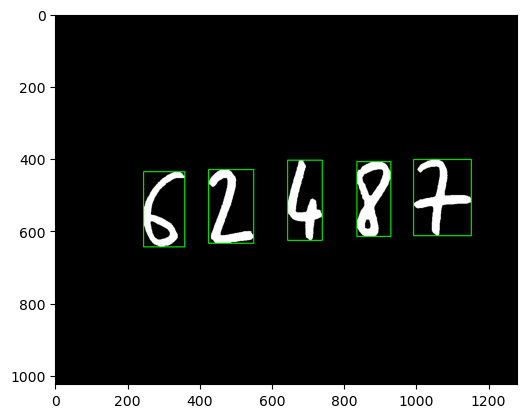

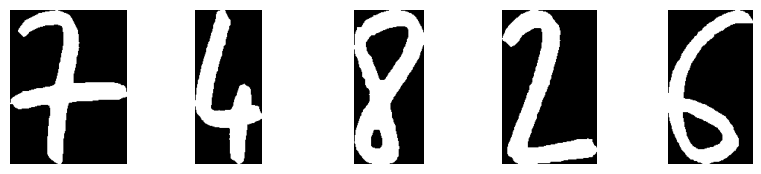

In [34]:

# Détecter et afficher les régions connectées
regions_image, digits = connectedRegion(eroded_image)
plt.imshow(regions_image)
# plt.show()
show_digits(digits)


## Dilatation 

In [35]:
def dilate_img(img: np.ndarray):
    """
    Applique la dilation à une image binaire dans quatre directions : 
    est, ouest, nord et sud.

    :param img: Image en niveaux de gris (binaire) de type numpy.ndarray.
    :return: Dictionnaire contenant les versions dilatées de l'image.
    """

    # Obtenir les dimensions de l'image
    V, H = img.shape  # V = Hauteur (Vertical), H = Largeur (Horizontal)

    # Définition des tailles des noyaux de dilation
    horizontal_size = 2 * H + 1  # Largeur du noyau horizontal
    vertical_size = 2 * V + 1    # Hauteur du noyau vertical

    # Création des noyaux de dilation
    kernel_horizontal = np.zeros((1, horizontal_size), dtype=np.uint8)
    kernel_horizontal[0, :H] = 1  # Partie gauche du noyau activée

    kernel_vertical = np.zeros((vertical_size, 1), dtype=np.uint8)
    kernel_vertical[:V, 0] = 1  # Partie haute du noyau activée

    # Appliquer la dilation dans chaque direction
    dilated_east = cv.dilate(img, kernel_horizontal, iterations=1)  # Vers l'est
    dilated_west = cv.dilate(img, np.flip(kernel_horizontal, axis=1), iterations=1)  # Vers l'ouest

    dilated_north = cv.dilate(img, kernel_vertical, iterations=1)  # Vers le nord
    dilated_south = cv.dilate(img, np.flip(kernel_vertical, axis=0), iterations=1)  # Vers le sud

    return {
        "east": dilated_east.astype("uint8"),
        "west": dilated_west.astype("uint8"),
        "south": dilated_south.astype("uint8"),
        "north": dilated_north.astype("uint8"),
    }


In [36]:
dilated_dict = dilate_img(digits[-1])

## Trouver les cavités

In [37]:
from typing import Dict

def find_calvitie(digit: np.ndarray, morph_dict: Dict[str, np.ndarray]):
    east_cavitie = (
        morph_dict["east"]
        & (255 - morph_dict["west"])
        & morph_dict["south"]
        & morph_dict["north"]
        & (255 - digit)
    )
    return east_cavitie


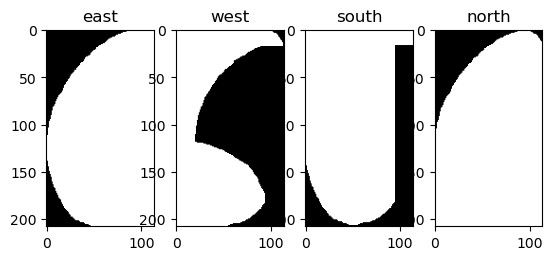

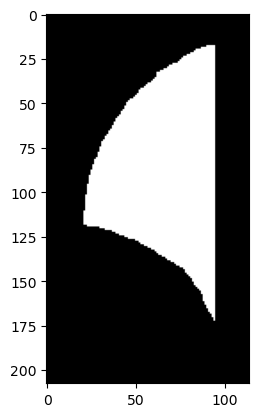

In [38]:
fig, axes = plt.subplots(1, len(dilated_dict))
for ax, (key, mat) in zip(axes, dilated_dict.items()):
    ax.imshow(mat, cmap="gray")
    ax.set_title(key)
plt.show()
plt.imshow(find_calvitie(digits[-1], dilated_dict), cmap="gray")
plt.show()


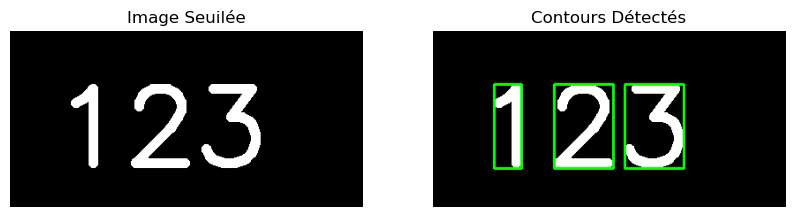

In [43]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Générer une image artificielle avec des chiffres (pour l'exemple)
image = np.zeros((200, 400), dtype=np.uint8)
cv.putText(image, "123", (50, 150), cv.FONT_HERSHEY_SIMPLEX, 4, (255,), 10, cv.LINE_AA)

# Étape 1 : Convertir en niveaux de gris (déjà en niveaux de gris)
gray = image.copy()

# Étape 2 : Appliquer un seuillage binaire
_, binary = cv.threshold(gray, 100, 255, cv.THRESH_BINARY)

# Étape 3 : Trouver les contours
contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Étape 4 : Dessiner les contours sur une image couleur
output = cv.cvtColor(binary, cv.COLOR_GRAY2BGR)
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    cv.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Affichage des images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(binary, cmap='gray')
ax[0].set_title("Image Seuilée")
ax[0].axis("off")

ax[1].imshow(output)
ax[1].set_title("Contours Détectés")
ax[1].axis("off")

plt.show()
